In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [21]:
rootpath = "../data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

In [4]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [5]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


initialize gmm using k-means++ (recommended and faster than k-means)

In [6]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

In [7]:
initial_gmm = init_gmm.initial_gaussian_mixtures('..', sub_id, trials, n_gaussians=300, seed=seed, fit_model=False)

In [8]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

In [10]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, initial_labels, initial_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 300, 30)
clusterless neural projections shape: (230, 300, 15)
clusterless neural reconstructions shape: (230, 300, 30)


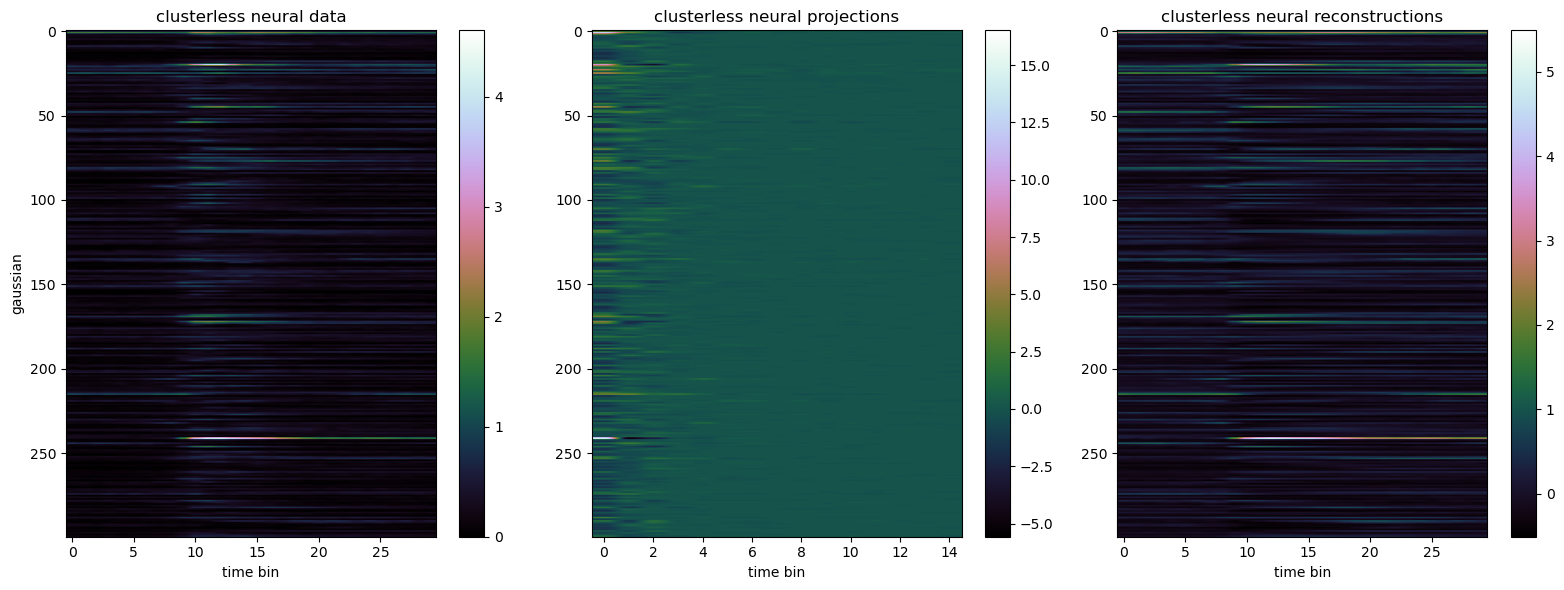

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [12]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.983
choice fold 2 test accuracy: 0.935 auc: 0.979
choice fold 3 test accuracy: 0.935 auc: 0.986
choice fold 4 test accuracy: 0.935 auc: 0.982
choice fold 5 test accuracy: 0.978 auc: 0.998
choice mean of 5-fold cv accuracy: 0.939 auc: 0.986
choice sd of 5-fold cv accuracy: 0.021 auc: 0.007
stimulus fold 1 test accuracy: 0.261 auc: 0.776
stimulus fold 2 test accuracy: 0.261 auc: 0.786
stimulus fold 3 test accuracy: 0.348 auc: 0.816
stimulus fold 4 test accuracy: 0.304 auc: 0.799
stimulus fold 5 test accuracy: 0.348 auc: 0.815
stimulus mean of 5-fold cv accuracy: 0.304 auc: 0.799
stimulus sd of 5-fold cv accuracy: 0.039 auc: 0.016


split with bayesian dirichlet process:
1. find gaussians to be split
2. fit bayesian gmm on identified gaussians to automatically decide K
3. check if feature MAD of new gaussians satisfy the split criteria
4. go back to step 1 and repeat for gaussians to be split
5. repeat till no gaussians need to be split according to the criteria

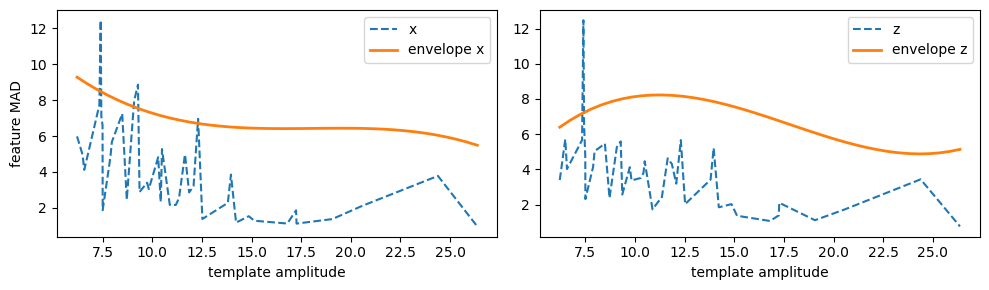

84 216


In [387]:
# plot smooth envelope for kilosort template feature MADs
split_ids, residual_ids = split_merge.split_criteria(structured_unsorted, initial_labels, use_ks_template=True)
print(len(split_ids), len(residual_ids))

now visualize gaussians to be split ...

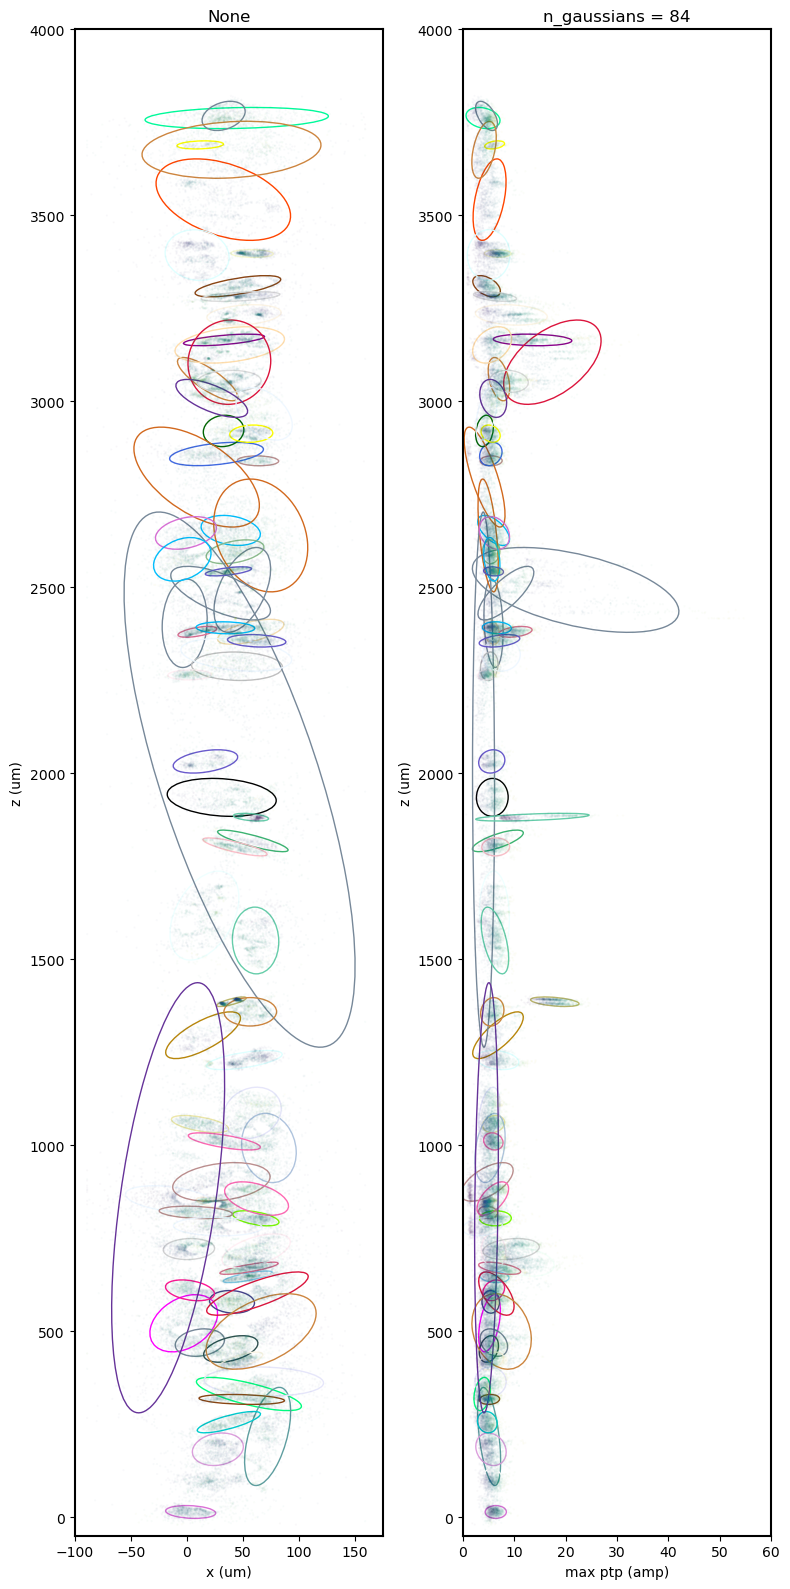

In [388]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, split_ids, display_all_spikes=False, n_spikes_display=1_000)

then visualize gaussians to be kept ...

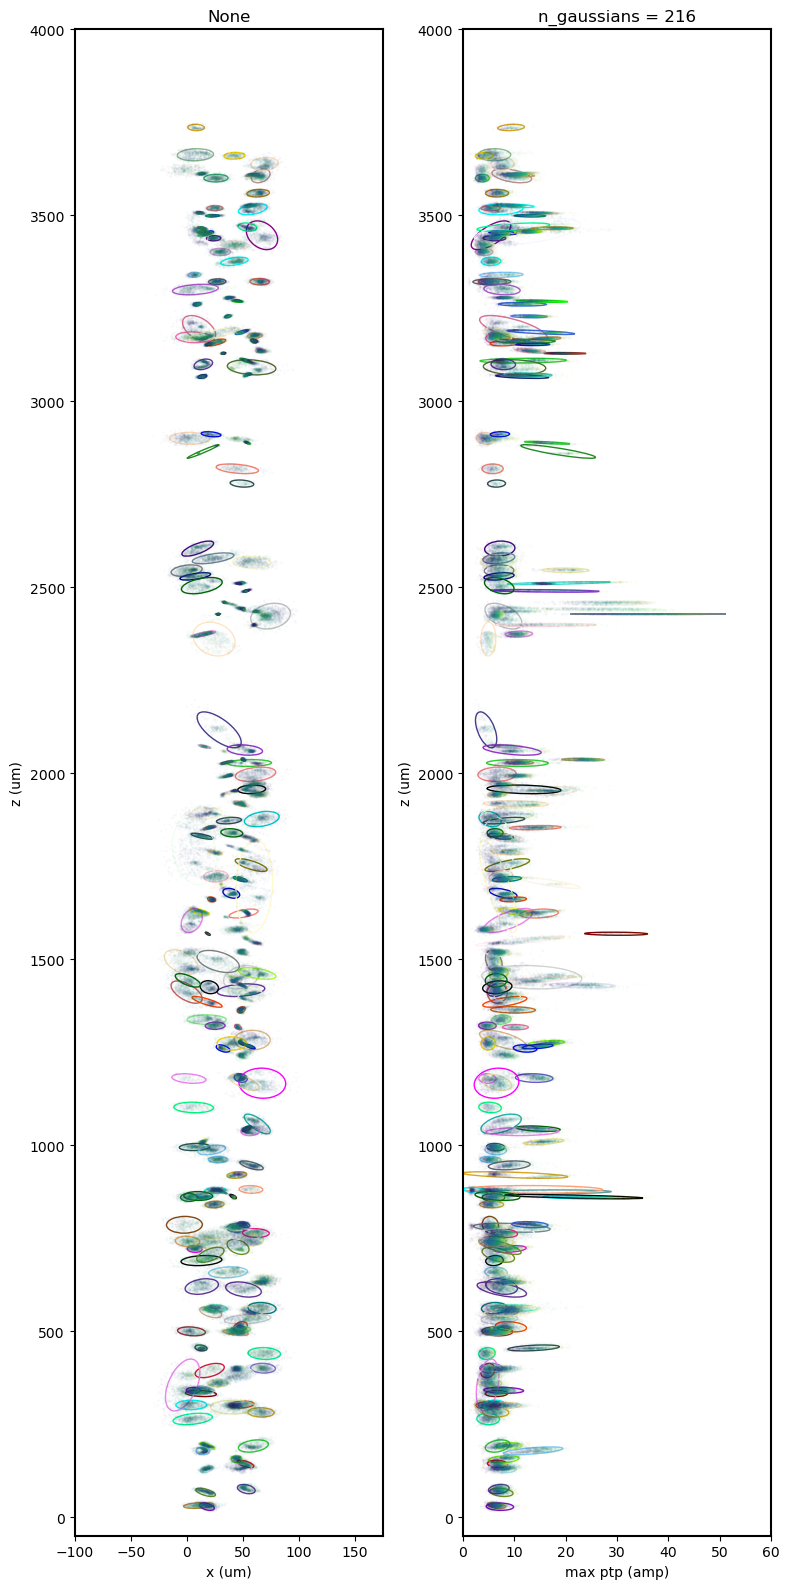

In [389]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, residual_ids, display_all_spikes=False, n_spikes_display=1_000)

zoom into one gaussian to investigate ...

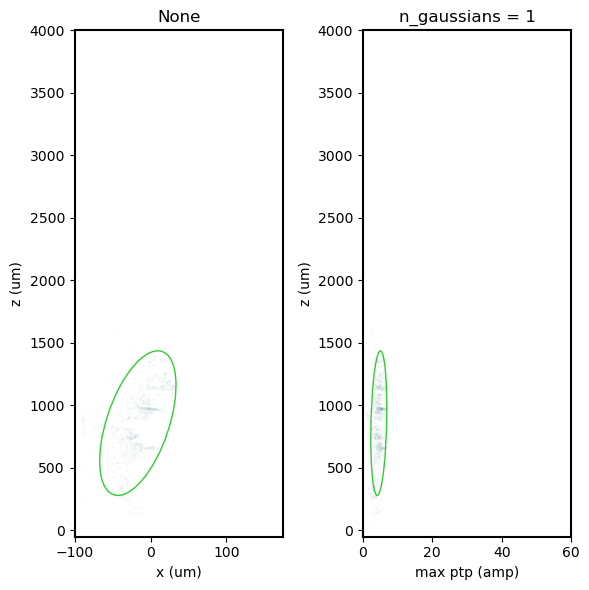

In [309]:
idx = -1
sub_spikes_train = structured_unsorted[initial_labels == split_ids[idx]]
plot_gmm_cluster_viz(sub_id, structured_unsorted, initial_labels, split_ids[idx], display_all_spikes=True, figure_size=(6,6))

this gaussian has large variances ...

In [294]:
np.cov(sub_spikes_train.transpose())

array([[6.34422484e+02, 3.80382033e+03, 1.05433780e+01],
       [3.80382033e+03, 8.35846074e+04, 6.80607730e+01],
       [1.05433780e+01, 6.80607730e+01, 1.32709461e+00]])

use an empirical prior for the covariance matrix to fit bayesian gmm ...

In [292]:
residual_vars = np.vstack([np.var(structured_unsorted[initial_labels == i], axis=0) for i in residual_ids])
empirical_cov_prior = np.zeros((3, 3))
empirical_cov_prior[range(3), range(3)] = np.mean(residual_vars, axis=0)

In [314]:
# use dirichlet process to choose K for each gaussian to be split
from sklearn.mixture import BayesianGaussianMixture
tmp_gmm = BayesianGaussianMixture(n_components=10, 
                          max_iter=2000,
                          n_init=4,
                          init_params='k-means++',
                          warm_start=True, verbose=1, verbose_interval=50,
                          weight_concentration_prior_type='dirichlet_process',
                          covariance_prior=empirical_cov_prior)
tmp_gmm.fit(sub_spikes_train)

Initialization 0
  Iteration 50
  Iteration 100
Initialization converged: True
Initialization 1
  Iteration 50
  Iteration 100
  Iteration 150
  Iteration 200
  Iteration 250
Initialization converged: True
Initialization 2
  Iteration 50
  Iteration 100
  Iteration 150
Initialization converged: True
Initialization 3
  Iteration 50
  Iteration 100
  Iteration 150
  Iteration 200
  Iteration 250
  Iteration 300
Initialization converged: True


BayesianGaussianMixture(covariance_prior=array([[21.59979309,  0.        ,  0.        ],
       [ 0.        , 37.62595295,  0.        ],
       [ 0.        ,  0.        ,  5.23444117]]),
                        init_params='k-means++', max_iter=2000, n_components=5,
                        n_init=4, verbose=1, verbose_interval=50,
                        warm_start=True)

look at the splitted gaussians ...

In [315]:
tmp_labels = tmp_gmm.predict(sub_spikes_train)
tmp_probs = tmp_gmm.predict_proba(sub_spikes_train)

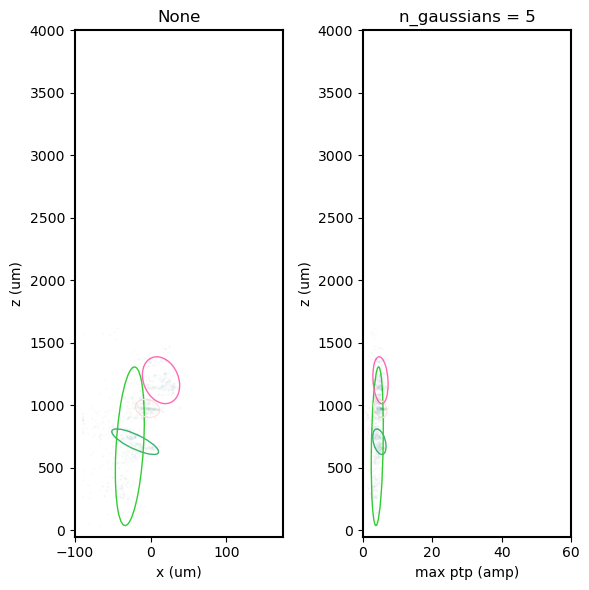

In [316]:
viz_tools.plot_gmm_cluster_bounds(sub_id, sub_spikes_train, tmp_labels, tmp_labels, figure_size=(6,6), display_all_spikes=True)

the goal is to keep spliting till no gaussians fall above the envelope ...

now iterate to do so ...

first put aside residuals gaussians that we want to keep ...

In [445]:
residual_ids = set(np.unique(initial_labels)).difference(set(split_ids))
print(f'keep {len(residual_ids)} gaussians and split {len(split_ids)} gaussians ...')

residual_weights = np.vstack([initial_gmm.weights_[i] for i in residual_ids]).squeeze()
residual_means = np.vstack([initial_gmm.means_[i] for i in residual_ids])
residual_covariances = np.stack([initial_gmm.covariances_[i] for i in residual_ids])

residual_gmm = GaussianMixture(n_components=len(residual_ids), covariance_type='full')
residual_gmm.weights_ = residual_weights
residual_gmm.means_ = residual_means
residual_gmm.covariances_ = residual_covariances
residual_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(residual_covariances))

residual_spikes_train = np.vstack([structured_unsorted[initial_labels == idx] for idx in residual_ids])
residual_labels = residual_gmm.predict(residual_spikes_train)
n_total = structured_unsorted.shape[0]
residual_fractions = [sum(residual_labels == i)/n_total for i in np.unique(residual_labels)]

residual_vars = np.vstack([np.var(structured_unsorted[initial_labels == i], axis=0) for i in residual_ids])
empirical_cov_prior = np.zeros((3, 3))
empirical_cov_prior[range(3), range(3)] = np.mean(residual_vars, axis=0)

keep 216 gaussians and split 84 gaussians ...


In [455]:
# check what an average covariance matrix looks like 
np.trace(empirical_cov_prior)

121.06935608776523

In [608]:
# while feature MAD fall above the envelope, do:

weights_lst = []
means_lst = []
covs_lst = []
labels_lst = []

for idx in split_ids:
    sub_spikes_train = structured_unsorted[initial_labels == idx]
    trace = np.trace(np.cov(sub_spikes_train.transpose()))
    
    # temporarily dropping very large gaussians
    if trace > 3000:
        continue
        
    # choose K based on the size of an average covariance matrix
    n_components = int(trace // (2*np.trace(empirical_cov_prior)))+1
    if n_components > len(sub_spikes_train):
        n_components = len(sub_spikes_train)
    
    # tmp_gmm = BayesianGaussianMixture(n_components=n_components, 
    #                       max_iter=2000,
    #                       n_init=1,
    #                       init_params='k-means++',
    #                       warm_start=True, verbose=0, 
    #                       weight_concentration_prior_type='dirichlet_process',
    #                       # covariance_type='diag')
    #                       covariance_prior=empirical_cov_prior)
    
    tmp_gmm = GaussianMixture(n_components=n_components, 
                          init_params='k-means++',
                          warm_start=True, verbose=0, 
                          covariance_type='full')
    tmp_gmm.fit(sub_spikes_train)
    weights_lst.append(tmp_gmm.weights_)
    means_lst.append(tmp_gmm.means_)
    covs_lst.append(tmp_gmm.covariances_)
    labels = tmp_gmm.predict(sub_spikes_train)
    labels_lst.append(labels)

    print(f'split {idx} with trace {round(trace, 2)} into {len(np.unique(labels))} gaussians ...')

split 6 with trace 1707.47 into 8 gaussians ...
split 10 with trace 401.06 into 2 gaussians ...
split 12 with trace 1047.0 into 5 gaussians ...
split 17 with trace 181.76 into 1 gaussians ...
split 29 with trace 499.79 into 3 gaussians ...
split 34 with trace 331.31 into 2 gaussians ...
split 44 with trace 141.61 into 1 gaussians ...
split 53 with trace 462.44 into 2 gaussians ...
split 56 with trace 129.92 into 1 gaussians ...
split 64 with trace 569.27 into 3 gaussians ...
split 65 with trace 1029.69 into 5 gaussians ...
split 68 with trace 583.82 into 3 gaussians ...
split 71 with trace 700.18 into 3 gaussians ...
split 76 with trace 464.97 into 2 gaussians ...
split 81 with trace 1196.66 into 5 gaussians ...
split 83 with trace 778.01 into 4 gaussians ...
split 88 with trace 295.44 into 2 gaussians ...
split 89 with trace 537.27 into 3 gaussians ...
split 96 with trace 684.56 into 3 gaussians ...
split 103 with trace 609.35 into 3 gaussians ...
split 104 with trace 315.4 into 2 gau

In [609]:
# to do: clean this up
# organize the results a bit to collapse everything into one MoG

fractions_lst = []
for labels in labels_lst:
    fractions = [sum(labels == i)/n_total for i in np.unique(labels)]
    fractions_lst.extend(fractions)
    
unique_means_lst = []
for i, means in enumerate(means_lst):
    labels = labels_lst[i]
    unique_means = [means[j] for j in np.unique(labels)]
    unique_means_lst.extend(unique_means)
    
unique_covs_lst = []
for i, covs in enumerate(covs_lst):
    labels = labels_lst[i]
    unique_covs = [covs[j] for j in np.unique(labels)]    # for cov_type = 'full'
    # unique_covs = [np.diag(covs[j]) for j in np.unique(labels)]  # for cov_type = 'diag'
    unique_covs_lst.append(unique_covs)

In [610]:
post_split_weights = np.hstack([residual_fractions, fractions_lst])
post_split_means = np.vstack([residual_means, np.vstack(unique_means_lst)])
post_split_covariances = np.vstack([residual_covariances, np.vstack(unique_covs_lst)])

post_split_gmm = GaussianMixture(n_components=len(post_split_weights), covariance_type='full')
post_split_gmm.weights_ = post_split_weights
post_split_gmm.means_ = post_split_means
post_split_gmm.covariances_ = post_split_covariances
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(post_split_covariances))

In [612]:
post_split_labels = post_split_gmm.predict(structured_unsorted)
post_split_probs = post_split_gmm.predict_proba(structured_unsorted)

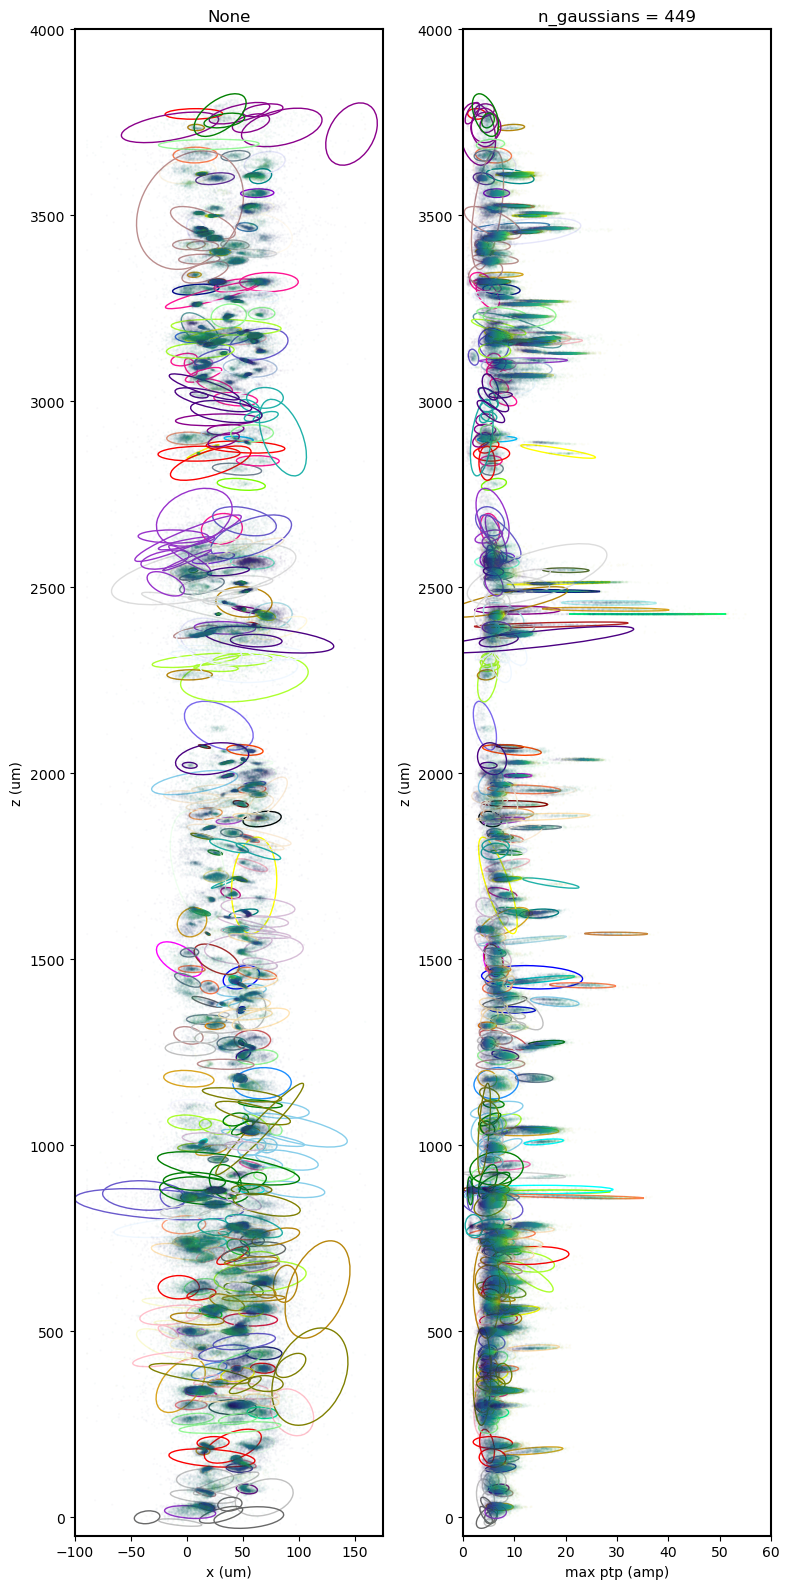

In [613]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, post_split_labels, post_split_labels, display_all_spikes=False, n_spikes_display=5_000)

now try decoding this new MoG after split-merge ...

In [614]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, post_split_labels, post_split_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 449, 30)
clusterless neural projections shape: (230, 449, 15)
clusterless neural reconstructions shape: (230, 449, 30)


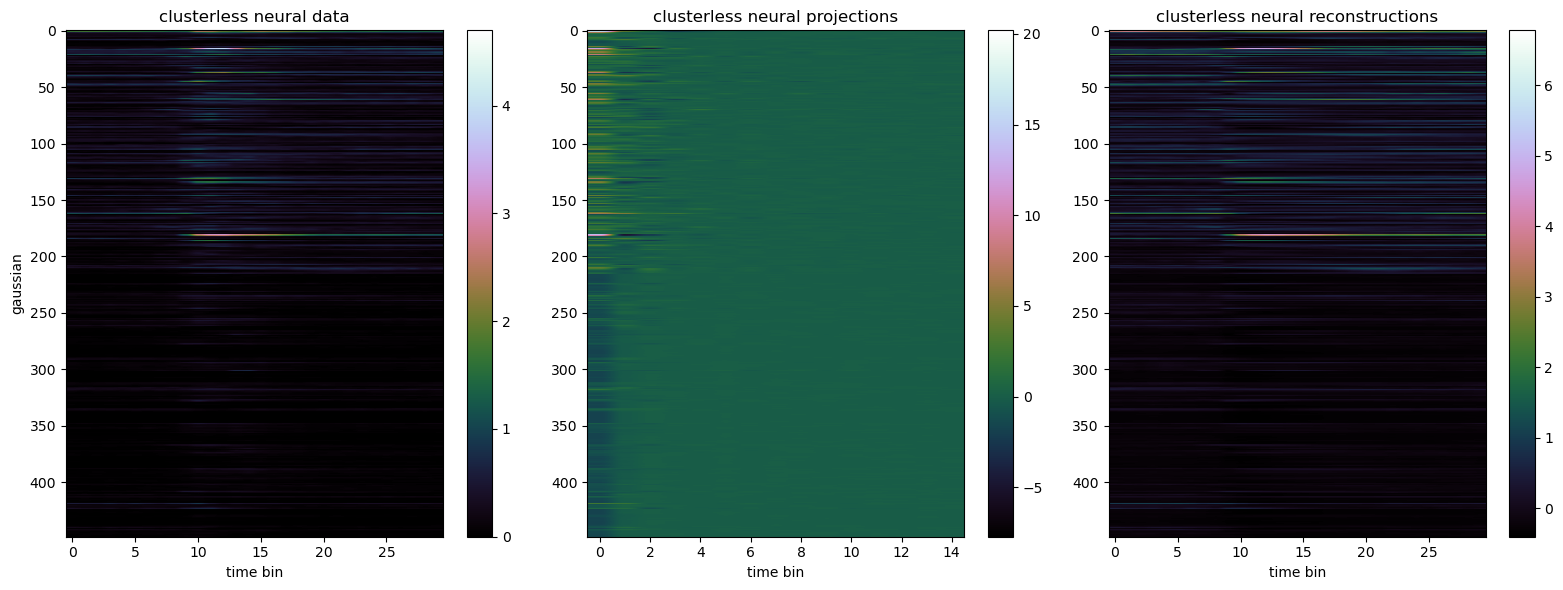

In [615]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [616]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.983
choice fold 2 test accuracy: 0.935 auc: 0.979
choice fold 3 test accuracy: 0.913 auc: 0.982
choice fold 4 test accuracy: 0.935 auc: 0.978
choice fold 5 test accuracy: 0.978 auc: 0.998
choice mean of 5-fold cv accuracy: 0.935 auc: 0.984
choice sd of 5-fold cv accuracy: 0.024 auc: 0.007
stimulus fold 1 test accuracy: 0.239 auc: 0.779
stimulus fold 2 test accuracy: 0.239 auc: 0.786
stimulus fold 3 test accuracy: 0.370 auc: 0.813
stimulus fold 4 test accuracy: 0.304 auc: 0.797
stimulus fold 5 test accuracy: 0.370 auc: 0.819
stimulus mean of 5-fold cv accuracy: 0.304 auc: 0.799
stimulus sd of 5-fold cv accuracy: 0.058 auc: 0.015


it looks like the large gaussians really have very low weights, \
so we can probably keep them as large gaussians since they contribute little to decoding. \
also, split-merge may not be ideal for clusterless decoding since \
we would want to avoid hard sorting and simply learn a mapping from spike features to weights. \
maybe we should choose a MoG that best describes the spike features data instead of \
a MoG that recovers spike sorting results by eye-balling? 

to do: visualize heat map of feature importance of MoG weights to see the contribution of large gaussians to decoding. 
https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn/67910281#67910281

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC

# partition train and test
x = clusterless_neural_data
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
train = np.random.choice(range(n_trials), int(n_trials*0.8))
test = list(set(range(n_trials)).difference(set(train)))
x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]

decoder = SVC(random_state=seed, max_iter=1e4, tol = 0.01, kernel='rbf', probability=True)
decoder.fit(x_train, y_train.argmax(1))

# match feature importance back to weight matrix for viz
perm_importance = permutation_importance(decoder, x_test, y_test.argmax(1)).importances_mean
perm_importance = perm_importance.reshape(x.shape[1], x.shape[-1])

p = plt.imshow(perm_importance, aspect='auto', cmap='cubehelix')
plt.set_title('MoG feature importance')
plt.set_xlabel('time bin')
plt.set_ylabel('gaussians')
plt.colorbar()
plt.show()

merge (use kl divergence as criteria)